### Nuclear Mass Predictor with Support Vector Machines
##### November 2020
##### Jeffrey T. Kwarsick, Ph.D.
#### Introduction

In [31]:
import numpy as np
import pandas as pd
import math
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import scipy as sci
from scipy import stats
import time
from datetime import datetime
plt.style.use('ggplot')

##### Date Block

In [2]:
today = datetime.now()
month = today.strftime("%b")
day   = today.strftime("%d")
year  = today.strftime("%Y")
print("Today is {0} {1}, {2}".format(month, day, year))

Today is Nov 27, 2020


#### Pre-processing Data from Atomic Mass Evaluation
Data used for model training is from the **Atomic Mass Evaluation** published in Chinese Physics C (Chinese Physics C Vol. 41, No. 3 (2017) 030002).  Access to this information can be found at this <a href="url" target="https://www-nds.iaea.org/amdc/">link.</a>

- I am using the **mass16.txt** file to extract data from.
    - This file contains a myriad of information for nuclei in the dataset.  These include:
        - N-Z
        - N (neutron number) **WANT THIS**
        - Z (proton number) **WANT THIS**
        - A (mass number, N + Z)
        - EL (Element Symbol) **WANT THIS**
        - O (decay channel)
        - Mass Excess (keV) **WANT THIS**
        - Binding Energy per Nucleon (BE/A, keV) **WANT THIS**
        - $\beta$-Decay Energy (keV) **WANT THIS**
        - Atomic Mass (micro-AMUs = millionths of Atomic Mass Units) **WANT THIS**
    - Many of these values have errors associated with their values, space separated.
    - Some values such as ATOMIC MASS has a space between it's first digit and the rest of the numbers
    - Some values have non-numeric values in their value that must be removed
    - Some instances do not have values at all and must be handled as NULL or something
    - Characters to remove:
        - "#" is some kind of rounding error thing
        - "*" is an empty value

In [3]:
file = "ame2016_nuclear_masses.txt"
num_lines = sum(1 for line in open(file))
print(num_lines)

3438


In [54]:
with open(file) as f:
    content = f.readlines()
f.close()
content = [line.rstrip('\n') for line in content]

In [55]:
foo = [line.replace('#', "") if "#" in line else line for line in content]
print(len(foo))

3438


In [100]:
foo[0]

'1N-Z    N    Z   A  EL    O     MASS EXCESS       BINDING ENERGY/A        BETA-DECAY ENERGY         ATOMIC MASS'

In [63]:
tmp = re.sub(r"(?<=[0-9]{1})\s{1}(?=.+)", "", foo[2])
tmp.split()

['0',
 '1',
 '1',
 '0',
 '1',
 'n',
 '8071.31713',
 '0.00046',
 '0.0',
 '0.0',
 'B-',
 '782.347',
 '0.000',
 '1008664.91582',
 '0.00049']

In [72]:
bar = [re.sub(r"(?<=\s[0-9]{1})\s{1}(?=[0-9])", "", x) for x in foo]
bar = [re.sub(r"(?<=\s[0-9]{2})\s{1}(?=[0-9])", "", x) for x in bar]
bar = [re.sub(r"(?<=\s[0-9]{3})\s{1}(?=[0-9])", "", x) for x in bar]
print(len(bar))

3438


(array([   0.,    4., 1413., 1731.,  288.,    0.]),
 array([12, 13, 14, 15, 16, 17, 18]),
 <BarContainer object of 6 artists>)

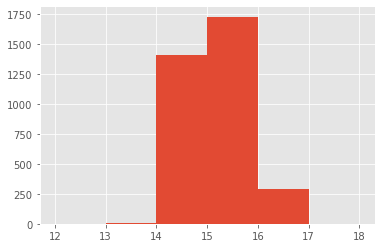

In [128]:
length_of_lines = [len(x.split()) for x in bar[2:]]
plt.hist(length_of_lines, bins=np.arange(12,19,1))

In [83]:
for i in range(len(bar)):
    if len(bar[i].split()) == 13:
        print(bar[i])

  -1    0    1    1 H          7288.97061    0.00009      0.0      0.0   B-      *                1007825.03224    0.00009
  -4    2    6    8 C         35064.268     18.243     3101.524    2.280 B-      *                8037643.042     19.584
  -4    7   11   18 Na        25037.988     93.881     6202.217    5.216 B-      *               18026879.386    100.785
   9   78   69  147 Tm       -35974.400      6.839     7948.817    0.047 B-      *              146961379.890      7.341


In [98]:
yarg = True
while yarg == True:
    tmp = np.random.randint(low = 0, high=len(bar))
    if len(bar[tmp].split()) == 15 or len(bar[tmp].split()) == 14:
        print(bar[tmp])
    else:
        yarg = False

  55  164  109  273 Mt   -a  134713       424        7265       2    B-  -3643     445    273144620       455
  -2   33   35   68 Br   -p  -38791       259        8239       4    B-      *               67958356       278
  35  126   91  217 Pa   -a   17068.410     15.918     7664.580    0.073 B-  -5905      73    217018323.692     17.089
  -2   45   47   92 Ag    x  -37130       500        8075       5    B-      *               91960139       537
  19   67   48  115 Cd       -88084.479      0.651     8510.724    0.006 B-   1451.867    0.651 114905437.417      0.699
  47  154  107  261 Bh   -a  113133       209        7317       1    B-      *              261121454       224
  36  120   84  204 Po   -a  -18341.244     11.013     7839.083    0.054 B-  -6465.811   24.860 203980309.863     11.822
  26  102   76  178 Os       -43544.270     13.632     7981.912    0.077 B-  -7292.386   24.006 177953253.300     14.634
  38  117   79  196 Au       -31138.706      2.962     7914.855    0.015

In [176]:
syms = re.findall(r"(?<=\s{1})([A-Z][a-z]?|n)(?=\s)", bar[409])[0]
reg = re.compile("([A-Z][a-z]?)(?=\s)")
el_sym = [re.findall(r"(?<=\s{1})([A-Z][a-z]?|n)(?=\s)", bar[i])[0] for i in range(2,len(bar))]
syms

'Ca'

In [132]:
out = [bar[i].split() for i in range(2,len(bar))]
out_tmp = [out[i][1:5] for i in range(len(out))]

In [149]:
idxs = [i for i, item in enumerate(out[6]) if re.search(r"([A-Z][a-z]?|n)", item)]

In [153]:
tes = [[i for i, item in enumerate(out[x]) if re.search(r"([A-Z][a-z]?|n)", item)] for x in range(len(out))]

In [159]:
tes[6]

[5, 6, 11]

In [180]:
out[1]

['-1',
 '0',
 '1',
 '1',
 'H',
 '7288.97061',
 '0.00009',
 '0.0',
 '0.0',
 'B-',
 '*',
 '1007825.03224',
 '0.00009']

In [188]:
A = [int(out[i][tes[i][0] - 1]) for i in range(len(tes))]
Z = [int(out[i][tes[i][0] - 2]) for i in range(len(tes))]
N = [int(out[i][tes[i][0] - 3]) for i in range(len(tes))]
N_Z = [(N[i] - Z[i]) for i in range(len(Z))]

In [192]:
test_df = pd.DataFrame(list(zip(el_sym, Z, N, A, N_Z)))
test_df.columns = ["Element_Symbol", "Z", "A", "N", "N-Z"]

In [191]:
test_df.query("Element_Symbol == 'Ag'")

,Element_Symbol,Z,A,N,N-Z
980,Ag,47,45,92,-2
994,Ag,47,46,93,-1
1008,Ag,47,47,94,0
1023,Ag,47,48,95,1
1037,Ag,47,49,96,2
1052,Ag,47,50,97,3
1067,Ag,47,51,98,4
1081,Ag,47,52,99,5
1096,Ag,47,53,100,6
1111,Ag,47,54,101,7
